## pytorch基础
大纲：
* 数据集
* 模型
* 损失
* 优化器

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

plt.rcParams.update({'font.size':16})

### 数据集
生产一个模拟数据：
$$
x \to y = Ax+b
$$

In [2]:
input_dim = 1
output_dim = 1

A = 2 * np.random.rand(output_dim, input_dim) -1
b = 2 * np.random.rand(output_dim) - 1

true_model = lambda x: A @ x + b


通过随机采样和添加噪声数据来获得训练集  
$$
y_i = Ax_i + b + v_i;\ x \in U([-1, 1])
$$

In [3]:
n_train = 1000
noise_level = 0.04

# 生产数据
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

# 添加一个噪声
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

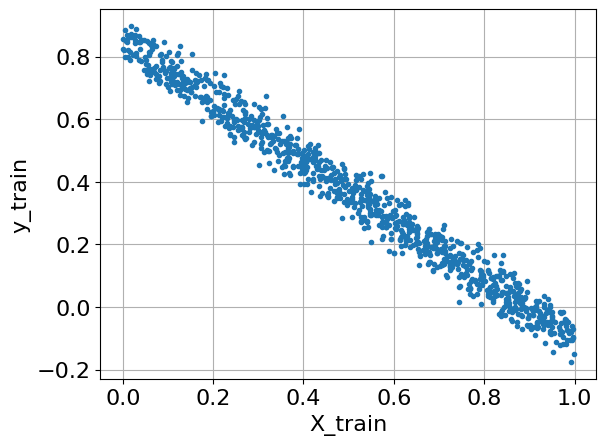

In [4]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

## pytorch 的 Dataset数据集

In [5]:
# 定义 torch 的 Dataset数据
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))

    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :], self.output_data[idx, :])
        return sample

In [6]:
training_set = VectorialDataset(input_data=X_train, output_data=y_train)

In [7]:
print(f'数据集size:{len(training_set)}')
print(f'取出样例：{training_set[10:12]}')

数据集size:1000
取出样例：(tensor([[0.5941],
        [0.7339]]), tensor([[0.2354],
        [0.1400]]))


### DataLoader组件
用于划分数据集

In [8]:
from torch.utils.data import DataLoader

batch_size = 120
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

In [9]:
for idx, batch in enumerate(train_loader):
    print(f'第{idx}批数据： 输入size: {batch[0].shape} , 输出size: {batch[1].shape}')

第0批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第1批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第2批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第3批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第4批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第5批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第6批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第7批数据： 输入size: torch.Size([120, 1]) , 输出size: torch.Size([120, 1])
第8批数据： 输入size: torch.Size([40, 1]) , 输出size: torch.Size([40, 1])


### 模型
现在，我们实现一个线性模型：  
$$
x \to model(x) = Ax + b
$$

In [11]:
import torch.nn as nn
import torch

## 线性模型
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)
    
    # 前向传播
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # 自定义参数重置方法
    def reset(self):
        self.linear.reset_parameters()

In [14]:
# 实例化模型
model = LinearModel(input_dim, output_dim)

In [20]:
# 模型检查
print(model)
# 查看参数
print(list(model.parameters()))
# 线性模型的权重-偏移量
print(f'权重：\n\t{model.linear.weight},\n偏移量：\n\t{model.linear.bias}')

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
[Parameter containing:
tensor([[-0.8911]], requires_grad=True), Parameter containing:
tensor([-0.6430], requires_grad=True)]
权重：
	Parameter containing:
tensor([[-0.8911]], requires_grad=True),
偏移量：
	Parameter containing:
tensor([-0.6430], requires_grad=True)


In [21]:
# 现在给出5个值，通过先前计算
x = torch.randn(5, input_dim)
print(f'前向计算：\n{model.forward(x)}')

前向计算：
tensor([[-0.1156],
        [-0.9949],
        [-1.9701],
        [-1.5303],
        [-2.8593]], grad_fn=<AddmmBackward0>)


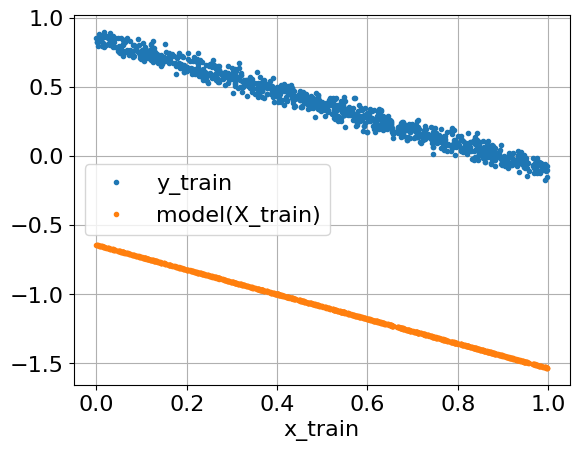

In [22]:
# 可视化训练数据，模型可视化
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
    ax.grid()
    ax.set_xlabel('x_train')
    ax.legend(['y_train', 'model(X_train)'])

### 损失函数
均方误差：  
$$
L(y, y^{'}) = ||y - y^{'}||_{2}^{2}
$$

In [23]:
import torch.nn as nn
loss_fun = nn.MSELoss(reduction='mean')

x = torch.tensor(np.array([1,2,1]).astype('f'))
z = torch.tensor(np.array([0,0,0]).astype('f'))

print(f'计算x和y的均方误差：{loss_fun(x, z)}')

计算x和y的均方误差：2.0


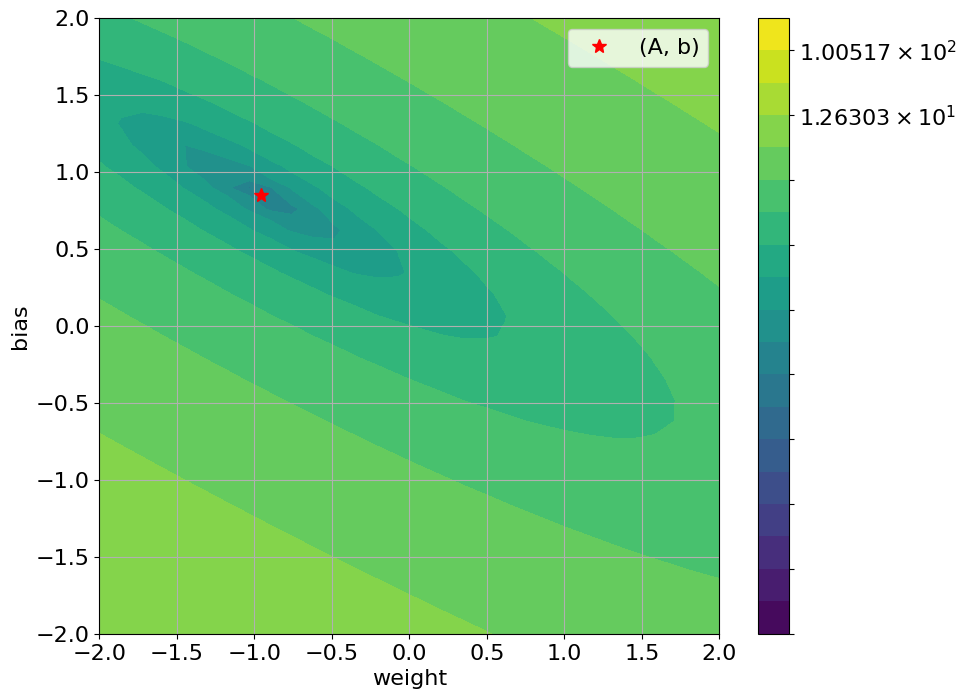

In [25]:
# 可视化
if input_dim == output_dim == 1:
    # 获取当前模型的参数字典(包含'linear.weight'和'linear.bias')
    state_dict = model.state_dict()

    # 创建2D网格：30x30的权重-偏置参数空间
    # 范围从-2~2， 用于探索不同参数组合
    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2,2,30))

    # 初始化损失值矩阵
    loss_values = 0 * ww

    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            # 遍历参数网格中的每个点
            
            # 临时设置模型的权重：shape[output_dim, input_dim]
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            # 临时设置模型的偏置：shape[output_dim, 1]
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])

            # 将临时参数加载到模型中
            model.load_state_dict(state_dict)

            # 计算均方误差
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data), training_set.output_data)
    
    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    # 创建对数间隔的等高线层级
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    # 绘制读书归一化的填充等高线图， 显示不同组合对应损失值
    c = ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    # 添加颜色条（显示损失值对应的颜色对应）
    plt.colorbar(c)
    # 在图中标记真实参数位置(A[0]是真实权重, b是真实偏置), 红色星号表示理论最优解位置
    ax.plot(A[0], b, 'r*', markersize=10)

    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    ax.legend(['(A, b)'])
    ax.grid(True)

In [26]:
# 后向计算
x = torch.randn(1, input_dim)
y = torch.randn(1, output_dim)

# 清零梯度
model.zero_grad()
loss = loss_fun(model.forward(x), y)
loss.backward()

In [27]:
if input_dim == output_dim == 1:
    print(f'torch计算的weight的梯度：{model.linear.weight.grad}')
    print(f'torch计算的bias的梯度：{model.linear.bias.grad}')
    print(f'手动计算的weight的梯度：{2*x*(model.linear.weight*x+model.linear.bias-y)}')
    print(f'手动计算的bias的梯度：{2*(model.linear.weight*x+model.linear.bias-y)}')

torch计算的weight的梯度：tensor([[7.8295]])
torch计算的bias的梯度：tensor([9.1938])
手动计算的weight的梯度：tensor([[7.8295]], grad_fn=<MulBackward0>)
手动计算的bias的梯度：tensor([[9.1938]], grad_fn=<MulBackward0>)


### 手工优化

In [30]:
# 输入/输出维度 = 1, 这是手动实现梯度下降的前提，高维情况无法观察
if input_dim == output_dim == 1:
    num_iter = 200
    lr = 0.5

    train_hist = {}
    train_hist['weight'] = []   # 初始化权重历史记录列表
    train_hist['bias'] = []     # 初始化偏置历史记录列表

    model.reset()               # 重置模型参数
    state_dict = model.state_dict()     # 获取当前参数字典
    
    # 训练循环
    for _ in range(num_iter):
        model.zero_grad()       # 清理上一轮计算的梯度
        # 1. 计算损失值
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        # 2. 反向传播: 自动计算所有参数的梯度(dL/dw, dL/db)
        loss.backward()
        # 3. 获取当前w, b, dw, db
        w = model.linear.weight.item()
        b = model.linear.bias.item()
        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        # 4. 手动更新参数: 关键
        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])

        # 5. 更新model参数
        model.load_state_dict(state_dict)

        # 6. 记录当前参数值-用于可视化
        train_hist['weight'].append(w)
        train_hist['bias'].append(b)
    
    # 将列表转化为numpy数组
    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

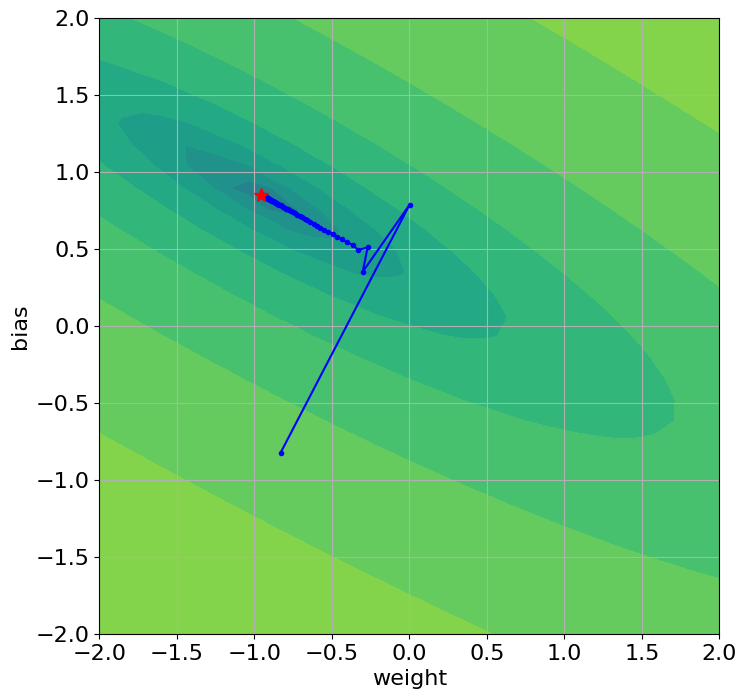

In [31]:
# 现在可视化手动优化的过程
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8,8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

### torch的optim优化

In [32]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [35]:
# 训练批次
n_epochs = 100
# 创建训练历史记录字典
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    # 初始化权重/偏置记录列表
    train_hist['weight'] = []
    train_hist['bias'] = []

model.reset()       # 重置模型参数
model.train()       # 设置模型为训练模式，允许训练

bar = tqdm(range(n_epochs))

for epoch in bar:                   # 外层循环：遍历所有训练轮次
    for idx, batch in enumerate(train_loader):  # 内存循环：遍历每个数据批次
        # train_loader 是 pytorch Dataloader 对象，提供批量数据迭代
        optimizer.zero_grad()   # 清楚上次梯度
        # 1. 计算损失
        loss = loss_fun(model.forward(batch[0]), batch[1])
        # 2. 反向计算
        loss.backward()
        # 3. 优化器更新参数
        optimizer.step()
        # 4. 记录损失值
        train_hist['loss'].append(loss.item())

        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item)   # 记录权重
            train_hist['bias'].append(model.linear.bias.item)       # 记录偏置
        bar.set_description(f'eopch:{epoch+1}/{n_epochs} - batch:{idx+1}/{len(train_loader)} loss: {loss.item()}')


model.eval()        # 设置模型为评估模式
        

eopch:100/100 - batch:9/9 loss: 0.0018306007841601968: 100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [37]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())    

RuntimeError: Could not infer dtype of builtin_function_or_method